# VLSI Physical Design - Complete Pipeline
# Step-by-Step Guide: From Data to GDS

## What This Notebook Does:

This notebook takes you through the **complete VLSI physical design flow** using Machine Learning:

1. **Setup & Installation** - Install required packages
2. **Data Loading** - Load CircuitNet dataset
3. **Data Understanding** - Explore and visualize the data
4. **Model Architecture** - Build GNN models
5. **Training** - Train placement prediction model
6. **Evaluation** - Test and visualize results
7. **Industry Visualization** - Micron-precision layouts
8. **Advanced Models** - Routing, congestion, timing
9. **GDS Export** - Integration with EDA tools
10. **Memory Cleanup** - Resource management

---

## Prerequisites:

- Python 3.8+
- 16GB+ RAM (32GB recommended)
- GPU with 8GB+ VRAM (optional but recommended)
- CircuitNet dataset downloaded

---

## Let's Begin!

---

# STEP 1: Setup & Installation

Install all required packages for VLSI physical design with ML.

In [3]:
# Install PyTorch first (CUDA 11.8)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

# Install PyTorch Geometric and extensions using pre-built wheels
!pip install torch-geometric -q
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.7.0+cu118.html -q

# Install other utilities
!pip install matplotlib numpy scipy pandas psutil -q

print("All packages installed successfully!")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


All packages installed successfully!



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


---

# STEP 2: Import Libraries

Import all necessary libraries for the pipeline.

In [4]:
# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch Geometric
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.loader import DataLoader

# Numerical and visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

# System utilities
import os
import time
import gc
import psutil
from scipy.spatial import KDTree
from collections import defaultdict, Counter

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"   PyTorch version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\nAll libraries imported successfully!")

Using device: cuda
   PyTorch version: 2.7.1+cu118
   GPU: NVIDIA GeForce RTX 4050 Laptop GPU
   GPU Memory: 6.44 GB

All libraries imported successfully!


---

# STEP 3: Configure Paths

Set up paths to your CircuitNet dataset.

In [5]:
# ============================================
# CONFIGURE YOUR CIRCUITNET PATHS HERE
# ============================================

CIRCUITNET_BASE = r"H:\Labs\Generative Ai\CircuitNet"

# Data paths
PLACEMENT_PATH = os.path.join(CIRCUITNET_BASE, "instance_placement_micron-002", "instance_placement_micron")
NODE_ATTR_PATH = os.path.join(CIRCUITNET_BASE, "graph_features", "graph_information", "node_attr")
NET_ATTR_PATH = os.path.join(CIRCUITNET_BASE, "graph_features", "graph_information", "net_attr")
CONGESTION_PATH = os.path.join(CIRCUITNET_BASE, "congestion")

# Verify paths exist
print("Verifying dataset paths...\n")

paths_to_check = {
    "Base Directory": CIRCUITNET_BASE,
    "Placement Data": PLACEMENT_PATH,
    "Node Attributes": NODE_ATTR_PATH,
    "Net Attributes": NET_ATTR_PATH,
}

all_exist = True
for name, path in paths_to_check.items():
    exists = os.path.exists(path)
    status = "[OK]" if exists else "[MISSING]"
    print(f"{status} {name}: {path}")
    if not exists:
        all_exist = False

print()
if all_exist:
    print("All paths verified! Ready to load data.")
else:
    print("WARNING: Some paths are missing. Please check your CircuitNet installation.")
    print("\nDownload from: https://drive.google.com/drive/folders/1GjW-1LBx1563bg3pHQGvhcEyK2A9sYUB")

Verifying dataset paths...

[OK] Base Directory: H:\Labs\Generative Ai\CircuitNet
[OK] Placement Data: H:\Labs\Generative Ai\CircuitNet\instance_placement_micron-002\instance_placement_micron
[OK] Node Attributes: H:\Labs\Generative Ai\CircuitNet\graph_features\graph_information\node_attr
[OK] Net Attributes: H:\Labs\Generative Ai\CircuitNet\graph_features\graph_information\net_attr

All paths verified! Ready to load data.


---

# STEP 4: Define Data Loaders

Functions to load and process CircuitNet data.

In [6]:
def get_design_name_from_placement(filename):
    """
    Extract base design name from placement filename
    e.g., '7873-zero-riscy-a-1-c20-u0.9-m1-p2-f1.npy' -> 'zero-riscy-a-1-c20'
    """
    name = os.path.splitext(filename)[0]
    parts = name.split('-')
    if parts[0].isdigit():
        parts = parts[1:]
    
    design_parts = []
    for p in parts:
        design_parts.append(p)
        if p.startswith('c') and p[1:].isdigit():
            break
    return '-'.join(design_parts)


def load_circuitnet_sample(placement_file):
    """
    Load a single CircuitNet sample and convert to PyTorch Geometric format
    """
    # Load placement data
    placement_path = os.path.join(PLACEMENT_PATH, placement_file)
    placement_raw = np.load(placement_path, allow_pickle=True)
    placement_dict = placement_raw.item() if hasattr(placement_raw, 'item') else placement_raw
    
    # Get design name
    design_name = get_design_name_from_placement(placement_file)
    
    # Load node attributes (optional)
    node_attr_file = os.path.join(NODE_ATTR_PATH, f"{design_name}_node_attr.npy")
    node_attr = None
    if os.path.exists(node_attr_file):
        try:
            node_attr = np.load(node_attr_file, allow_pickle=True)
        except:
            node_attr = None
    
    # Extract cell information
    cell_names = list(placement_dict.keys())
    num_nodes = len(cell_names)
    
    # Extract coordinates and sizes
    coords = []
    sizes = []
    for name in cell_names:
        bbox = placement_dict[name]  # [x_min, y_min, x_max, y_max]
        x_center = (bbox[0] + bbox[2]) / 2
        y_center = (bbox[1] + bbox[3]) / 2
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        coords.append([x_center, y_center])
        sizes.append([width, height])
    
    coords = np.array(coords, dtype=np.float32)
    sizes = np.array(sizes, dtype=np.float32)
    
    # Normalize coordinates to [0, 1]
    coords_norm = (coords - coords.min(axis=0)) / (coords.max(axis=0) - coords.min(axis=0) + 1e-8)
    sizes_norm = sizes / (sizes.max() + 1e-8)
    
    # Create node features: [x, y, width, height, log_area, cell_type, ...]
    node_features = np.zeros((num_nodes, 10), dtype=np.float32)
    node_features[:, 0:2] = coords_norm
    node_features[:, 2:4] = sizes_norm
    node_features[:, 4] = np.log1p(sizes[:, 0] * sizes[:, 1])
    
    # Add cell type encoding if available (with shape checking)
    if node_attr is not None and node_attr.shape[0] == 2:
        cell_types = node_attr[1]
        # Only use cell types if they match the number of nodes
        if len(cell_types) == num_nodes:
            unique_types = list(set(cell_types))
            type_to_idx = {t: i for i, t in enumerate(unique_types)}
            type_encoding = np.array([type_to_idx.get(t, 0) for t in cell_types])
            if len(unique_types) > 1:
                node_features[:, 5] = type_encoding / (len(unique_types) - 1)
    
    # Create spatial connectivity (k-nearest neighbors)
    k_neighbors = min(8, num_nodes - 1)
    if num_nodes > 1:
        tree = KDTree(coords_norm)
        _, indices = tree.query(coords_norm, k=k_neighbors + 1)
        src = np.repeat(np.arange(num_nodes), k_neighbors)
        dst = indices[:, 1:].flatten()
        edge_index = np.stack([src, dst], axis=0).astype(np.int64)
    else:
        edge_index = np.array([[0], [0]], dtype=np.int64)
    
    # Convert to PyTorch tensors
    data = Data(
        x=torch.tensor(node_features, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        y=torch.tensor(coords_norm, dtype=torch.float)
    )
    data.num_cells = num_nodes
    data.sample_name = os.path.splitext(placement_file)[0]
    data.design_name = design_name
    data.original_coords = torch.tensor(coords, dtype=torch.float)
    
    return data


def load_circuitnet_dataset(max_samples=100):
    """
    Load multiple CircuitNet samples as a dataset
    """
    samples = [f for f in os.listdir(PLACEMENT_PATH) if f.endswith('.npy')][:max_samples]
    
    if not samples:
        print("No samples found!")
        return None
    
    dataset = []
    errors = 0
    print(f"Loading {len(samples)} CircuitNet samples...")
    
    for i, sample_file in enumerate(samples):
        try:
            data = load_circuitnet_sample(sample_file)
            dataset.append(data)
            if (i + 1) % 50 == 0:
                print(f"   Loaded {i+1}/{len(samples)} samples... ({len(dataset)} successful, {errors} errors)")
        except Exception as e:
            errors += 1
            if errors <= 3:  # Only show first 3 errors
                print(f"   WARNING: Error loading {sample_file}: {str(e)[:80]}")
    
    if errors > 3:
        print(f"   ... and {errors - 3} more errors (suppressed)")
    
    print(f"\nLoaded {len(dataset)} samples successfully! ({errors} failed)")
    return dataset


print("Data loader functions defined!")

Data loader functions defined!


---

# STEP 5: Load Dataset

Load CircuitNet samples into memory.

**Adjust `max_samples` based on your RAM:**
- 16GB RAM: Use 100-200 samples
- 32GB RAM: Use 500-1000 samples
- 64GB RAM: Use 2000+ samples

In [7]:
# Load dataset
MAX_SAMPLES = 500  # Adjust based on your RAM

print(f"Loading {MAX_SAMPLES} samples from CircuitNet...\n")
circuitnet_dataset = load_circuitnet_dataset(max_samples=MAX_SAMPLES)

if circuitnet_dataset:
    # Split into train/test (80/20)
    split_idx = int(len(circuitnet_dataset) * 0.8)
    cn_train = circuitnet_dataset[:split_idx]
    cn_test = circuitnet_dataset[split_idx:]
    
    print(f"\nDataset Statistics:")
    print(f"   Total samples: {len(circuitnet_dataset)}")
    print(f"   Training samples: {len(cn_train)}")
    print(f"   Test samples: {len(cn_test)}")
    print(f"   Cells per sample: ~{circuitnet_dataset[0].num_cells:,}")
    print(f"   Edges per sample: ~{circuitnet_dataset[0].edge_index.shape[1]:,}")
    print(f"\nDataset ready for training!")
else:
    print("Failed to load dataset. Check your paths!")

Loading 500 samples from CircuitNet...

Loading 500 CircuitNet samples...
   Loaded 50/500 samples... (50 successful, 0 errors)
   Loaded 100/500 samples... (100 successful, 0 errors)
   Loaded 150/500 samples... (150 successful, 0 errors)
   Loaded 200/500 samples... (200 successful, 0 errors)
   Loaded 250/500 samples... (250 successful, 0 errors)
   Loaded 300/500 samples... (300 successful, 0 errors)
   Loaded 350/500 samples... (350 successful, 0 errors)
   Loaded 400/500 samples... (400 successful, 0 errors)
   Loaded 450/500 samples... (450 successful, 0 errors)
   Loaded 500/500 samples... (500 successful, 0 errors)

Loaded 500 samples successfully! (0 failed)

Dataset Statistics:
   Total samples: 500
   Training samples: 400
   Test samples: 100
   Cells per sample: ~52,147
   Edges per sample: ~417,176

Dataset ready for training!


---

# STEP 6: Explore Sample Data

Let's look at a single sample to understand the data structure.

In [8]:
# Explore a sample
if circuitnet_dataset:
    sample = circuitnet_dataset[0]
    
    print("Sample Data Structure:\n")
    print(f"Sample Name: {sample.sample_name}")
    print(f"Design: {sample.design_name}")
    print(f"Number of cells: {sample.num_cells:,}")
    print(f"Number of edges: {sample.edge_index.shape[1]:,}")
    print(f"\nNode features shape: {sample.x.shape}")
    print(f"   - Feature vector per cell: {sample.x.shape[1]} dimensions")
    print(f"   - [x, y, width, height, log_area, cell_type, ...]")
    print(f"\nTarget coordinates shape: {sample.y.shape}")
    print(f"   - (x, y) position per cell")
    print(f"\nEdge index shape: {sample.edge_index.shape}")
    print(f"   - Spatial connectivity between cells")
    
    print(f"\nSample Feature Statistics:")
    print(f"   X coord range: [{sample.x[:, 0].min():.3f}, {sample.x[:, 0].max():.3f}]")
    print(f"   Y coord range: [{sample.x[:, 1].min():.3f}, {sample.x[:, 1].max():.3f}]")
    print(f"   Width range: [{sample.x[:, 2].min():.3f}, {sample.x[:, 2].max():.3f}]")
    print(f"   Height range: [{sample.x[:, 3].min():.3f}, {sample.x[:, 3].max():.3f}]")
    
    print("\nSample exploration complete!")

Sample Data Structure:

Sample Name: 1-RISCY-a-1-c2-u0.7-m1-p1-f0
Design: RISCY-a-1-c2
Number of cells: 52,147
Number of edges: 417,176

Node features shape: torch.Size([52147, 10])
   - Feature vector per cell: 10 dimensions
   - [x, y, width, height, log_area, cell_type, ...]

Target coordinates shape: torch.Size([52147, 2])
   - (x, y) position per cell

Edge index shape: torch.Size([2, 417176])
   - Spatial connectivity between cells

Sample Feature Statistics:
   X coord range: [0.000, 1.000]
   Y coord range: [0.000, 1.000]
   Width range: [0.002, 1.000]
   Height range: [0.004, 0.757]

Sample exploration complete!


---

# STEP 7: Define GNN Model

Create the Graph Attention Network for placement prediction.

In [9]:
class VLSIPlacementGNN(nn.Module):
    """
    Graph Attention Network for VLSI cell placement prediction
    
    Architecture:
    - Input: Node features (x, y, width, height, area, type, ...)
    - 4 GAT layers with attention mechanism
    - Output: (x, y) coordinates for each cell
    """
    
    def __init__(self, input_dim=10, hidden_dim=128, output_dim=2, num_layers=4, heads=4):
        super(VLSIPlacementGNN, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        # Input projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # GAT layers with attention
        self.gat_layers = nn.ModuleList()
        for i in range(num_layers):
            in_channels = hidden_dim
            out_channels = hidden_dim if i < num_layers - 1 else hidden_dim
            self.gat_layers.append(
                GATConv(in_channels, out_channels // heads, heads=heads, dropout=0.1, concat=True)
            )
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Sigmoid()  # Output in [0, 1] range
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Input projection
        x = self.input_proj(x)
        x = F.relu(x)
        
        # GAT layers
        for i, gat_layer in enumerate(self.gat_layers):
            x = gat_layer(x, edge_index)
            if i < len(self.gat_layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.1, training=self.training)
        
        # Output projection
        out = self.output_proj(x)
        
        return out

# Create model
model = VLSIPlacementGNN(
    input_dim=10,
    hidden_dim=128,
    output_dim=2,
    num_layers=4,
    heads=4
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:\n")
print(model)
print(f"\nModel Statistics:")
print(f"   Total parameters: {num_params:,}")
print(f"   Input features: 10 dimensions")
print(f"   Hidden dimensions: 128")
print(f"   Output: (x, y) coordinates")
print(f"   Attention heads: 4")
print(f"   Device: {device}")
print("\nModel created successfully!")

Model Architecture:

VLSIPlacementGNN(
  (input_proj): Linear(in_features=10, out_features=128, bias=True)
  (gat_layers): ModuleList(
    (0-3): 4 x GATConv(128, 32, heads=4)
  )
  (output_proj): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
    (4): Sigmoid()
  )
)

Model Statistics:
   Total parameters: 76,866
   Input features: 10 dimensions
   Hidden dimensions: 128
   Output: (x, y) coordinates
   Attention heads: 4
   Device: cuda

Model created successfully!


---

# STEP 8: Define Training Loop

Set up optimizer, loss function, and training procedure.

---

# STEP 7.5: Legalization Functions

Convert raw GNN predictions to legal, row-aligned placements.

**Important:** GNN produces global placement (continuous coordinates). This step performs:
- Row alignment (snap to placement rows)
- Site snapping (align to grid sites)
- Overlap removal (prevent cell overlaps)

In [10]:
def legalize_placement(predictions, chip_width_um=1000, chip_height_um=1000, 
                       row_height_um=2.0, site_width_um=0.2):
    """
    Legalize GNN placement predictions to meet physical design constraints
    
    Steps:
    1. Scale from [0,1] to real chip dimensions (microns)
    2. Snap Y-coordinates to placement rows
    3. Snap X-coordinates to site grid
    4. Remove overlaps using force-directed approach
    
    Args:
        predictions: Normalized [0,1] coordinates from GNN
        chip_width_um: Chip width in microns
        chip_height_um: Chip height in microns
        row_height_um: Standard cell row height
        site_width_um: Placement site width
    
    Returns:
        legalized_coords: Physical coordinates aligned to rows and sites
    """
    
    # Step 1: Scale to real dimensions
    scaled_coords = predictions.copy()
    scaled_coords[:, 0] *= chip_width_um
    scaled_coords[:, 1] *= chip_height_um
    
    # Step 2: Snap to rows (Y-coordinate alignment)
    num_rows = int(chip_height_um / row_height_um)
    for i in range(len(scaled_coords)):
        row_idx = int(scaled_coords[i, 1] / row_height_um)
        row_idx = np.clip(row_idx, 0, num_rows - 1)
        scaled_coords[i, 1] = row_idx * row_height_um + row_height_um / 2
    
    # Step 3: Snap to sites (X-coordinate alignment)
    num_sites = int(chip_width_um / site_width_um)
    for i in range(len(scaled_coords)):
        site_idx = int(scaled_coords[i, 0] / site_width_um)
        site_idx = np.clip(site_idx, 0, num_sites - 1)
        scaled_coords[i, 0] = site_idx * site_width_um
    
    # Step 4: Simple overlap removal (force-directed)
    legalized = scaled_coords.copy()
    cell_width = site_width_um * 5  # Assume cells are ~5 sites wide
    
    # Iterative overlap resolution
    for iteration in range(10):
        overlap_found = False
        for i in range(len(legalized)):
            for j in range(i + 1, len(legalized)):
                # Check if cells are on same row
                if abs(legalized[i, 1] - legalized[j, 1]) < row_height_um / 2:
                    x_dist = abs(legalized[i, 0] - legalized[j, 0])
                    if x_dist < cell_width:
                        # Overlap detected - push apart
                        overlap_found = True
                        if legalized[i, 0] < legalized[j, 0]:
                            shift = (cell_width - x_dist) / 2
                            legalized[i, 0] -= shift
                            legalized[j, 0] += shift
                        else:
                            shift = (cell_width - x_dist) / 2
                            legalized[i, 0] += shift
                            legalized[j, 0] -= shift
                        
                        # Ensure within bounds
                        legalized[i, 0] = np.clip(legalized[i, 0], 0, chip_width_um)
                        legalized[j, 0] = np.clip(legalized[j, 0], 0, chip_width_um)
        
        if not overlap_found:
            break
    
    # Final site snap after overlap removal
    for i in range(len(legalized)):
        site_idx = int(legalized[i, 0] / site_width_um)
        site_idx = np.clip(site_idx, 0, num_sites - 1)
        legalized[i, 0] = site_idx * site_width_um
    
    return legalized


def compare_global_vs_legal(predictions, legalized, sample_name="sample"):
    """
    Visualize difference between global placement and legalized placement
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Global placement (raw GNN output)
    ax1 = axes[0]
    ax1.scatter(predictions[:, 0], predictions[:, 1], c='red', s=5, alpha=0.6, label='Global Placement')
    ax1.set_xlabel('X (µm)', fontsize=12)
    ax1.set_ylabel('Y (µm)', fontsize=12)
    ax1.set_title('Global Placement (Raw GNN Output)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Legalized placement
    ax2 = axes[1]
    ax2.scatter(legalized[:, 0], legalized[:, 1], c='green', s=5, alpha=0.6, label='Legalized Placement')
    ax2.set_xlabel('X (µm)', fontsize=12)
    ax2.set_ylabel('Y (µm)', fontsize=12)
    ax2.set_title('Legalized Placement (Row-Aligned, Site-Snapped)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(f'{sample_name}_global_vs_legal.png', dpi=100)
    plt.show()
    
    # Calculate displacement
    displacement = np.linalg.norm(legalized - predictions, axis=1)
    print(f"\nLegalization Impact:")
    print(f"   Average displacement: {np.mean(displacement):.2f} µm")
    print(f"   Max displacement: {np.max(displacement):.2f} µm")
    print(f"   Cells moved: {np.sum(displacement > 0.1)}/{len(displacement)}")
    
    # Check row alignment
    unique_rows = len(np.unique(legalized[:, 1]))
    print(f"   Cells placed in {unique_rows} rows")
    
    return displacement


print("Legalization functions defined!")
print("\nNote: GNN performs GLOBAL PLACEMENT only.")
print("Legalization converts continuous predictions to legal placements.")

Legalization functions defined!

Note: GNN performs GLOBAL PLACEMENT only.
Legalization converts continuous predictions to legal placements.


In [11]:
# Training configuration
BATCH_SIZE = 1  # Process one design at a time (large graphs)
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print("Training Configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Loss function: MSE (Mean Squared Error)")
print(f"   Optimizer: Adam")
print("\nTraining setup complete!")

Training Configuration:
   Batch size: 1
   Learning rate: 0.001
   Epochs: 20
   Loss function: MSE (Mean Squared Error)
   Optimizer: Adam

Training setup complete!


---

# STEP 9: Train the Model

Train the GNN on CircuitNet data. This may take 15-30 minutes depending on your GPU.

In [12]:
# Training loop with resume capability
train_losses = []
test_losses = []
start_epoch = 0

# Check if model exists and load it
model_save_path = r"H:\Labs\Generative Ai\vlsi_placement_model.pth"

if os.path.exists(model_save_path):
    print("=" * 80)
    print("LOADING EXISTING MODEL")
    print("=" * 80)
    
    checkpoint = torch.load(model_save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint.get('train_losses', [])
    test_losses = checkpoint.get('test_losses', [])
    
    print(f"Model loaded from: {model_save_path}")
    print(f"   Previous epochs completed: {start_epoch}")
    print(f"   Previous train loss: {train_losses[-1]:.6f}" if train_losses else "   No previous train loss")
    print(f"   Previous test loss: {test_losses[-1]:.6f}" if test_losses else "   No previous test loss")
    print(f"   Resuming training from epoch {start_epoch + 1}")
    print("=" * 80)
    print()
else:
    print("=" * 80)
    print("STARTING TRAINING FROM SCRATCH")
    print("=" * 80)
    print()

print("Starting Training...\n")
print("=" * 80)

start_time = time.time()

for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    batch_count = 0
    
    # Training
    for data in cn_train:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        pred = model(data)
        loss = criterion(pred, data.y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
    
    avg_train_loss = epoch_loss / batch_count
    train_losses.append(avg_train_loss)
    
    # Evaluation
    model.eval()
    test_loss = 0
    test_count = 0
    
    with torch.no_grad():
        for data in cn_test:
            data = data.to(device)
            pred = model(data)
            loss = criterion(pred, data.y)
            test_loss += loss.item()
            test_count += 1
    
    avg_test_loss = test_loss / test_count
    test_losses.append(avg_test_loss)
    
    # Print progress
    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1:2d}/{start_epoch + NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.6f} | "
          f"Test Loss: {avg_test_loss:.6f} | "
          f"Time: {elapsed:.1f}s")

print("=" * 80)
print(f"\nTraining complete! Total time: {elapsed/60:.1f} minutes")
print(f"   Final train loss: {train_losses[-1]:.6f}")
print(f"   Final test loss: {test_losses[-1]:.6f}")
print(f"   Total epochs completed: {start_epoch + NUM_EPOCHS}")

LOADING EXISTING MODEL
Model loaded from: H:\Labs\Generative Ai\vlsi_placement_model.pth
   Previous epochs completed: 20
   Previous train loss: 0.000361
   Previous test loss: 0.000049
   Resuming training from epoch 21

Starting Training...

Epoch 21/40 | Train Loss: 0.000273 | Test Loss: 0.000030 | Time: 25.3s
Epoch 22/40 | Train Loss: 0.000409 | Test Loss: 0.000155 | Time: 49.3s
Epoch 23/40 | Train Loss: 0.000365 | Test Loss: 0.000053 | Time: 73.3s
Epoch 24/40 | Train Loss: 0.000292 | Test Loss: 0.000095 | Time: 100.3s


KeyboardInterrupt: 

---

# STEP 10: Visualize Training Progress

Plot the training and test loss curves.

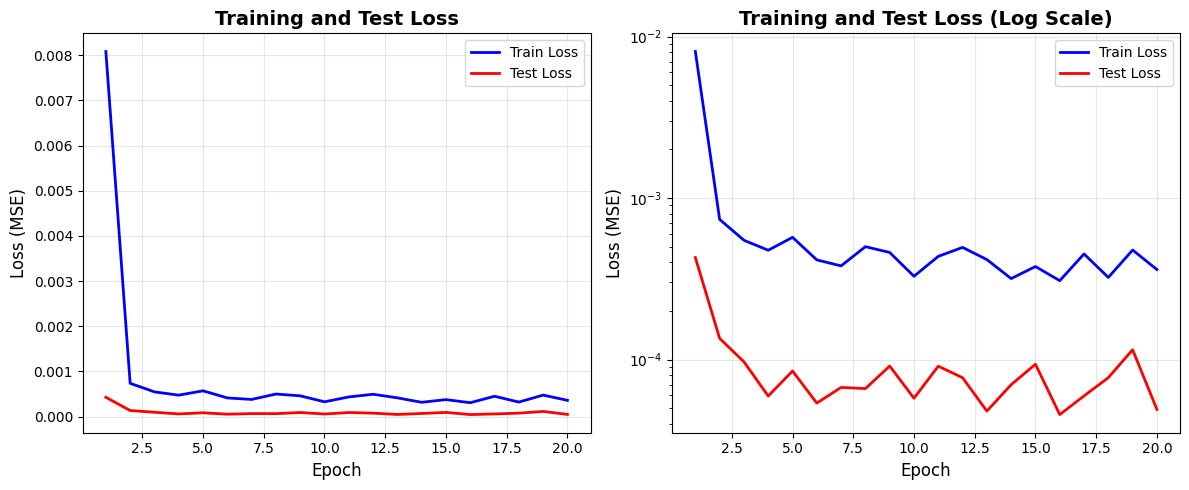

Training curves plotted!


In [ ]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss (Log Scale)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Training curves plotted!")

---

# STEP 11: Test Model Predictions

Run the trained model on a test sample and visualize results.

In [ ]:
# Test on a sample
model.eval()
test_sample = cn_test[0].to(device)

with torch.no_grad():
    pred_coords = model(test_sample).cpu().numpy()

actual_coords = test_sample.y.cpu().numpy()

# IMPORTANT: Perform legalization on predictions
print("=" * 80)
print("GLOBAL PLACEMENT → LEGALIZATION")
print("=" * 80)

# Scale predictions to microns for legalization
pred_microns = pred_coords * np.array([1000, 1000])
legalized_coords = legalize_placement(pred_microns, chip_width_um=1000, chip_height_um=1000)

# Visualize global vs legal
compare_global_vs_legal(pred_microns, legalized_coords, sample_name=test_sample.sample_name)

# Calculate error (using normalized coordinates for comparison)
error = np.sqrt(np.sum((pred_coords - actual_coords) ** 2, axis=1))
mean_error = np.mean(error)
max_error = np.max(error)

print(f"\nTest Sample Prediction Results (Global Placement):\n")
print(f"Sample: {test_sample.sample_name}")
print(f"Number of cells: {test_sample.num_cells:,}")
print(f"\nGlobal Placement Accuracy (vs Ground Truth):")
print(f"   Mean placement error: {mean_error:.6f}")
print(f"   Max placement error: {max_error:.6f}")
print(f"   Min placement error: {np.min(error):.6f}")
print(f"   Std placement error: {np.std(error):.6f}")

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Actual placement
axes[0].scatter(actual_coords[:, 0], actual_coords[:, 1], c='blue', s=1, alpha=0.5)
axes[0].set_title('Ground Truth', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X (normalized)')
axes[0].set_ylabel('Y (normalized)')
axes[0].grid(True, alpha=0.3)

# Global placement (raw GNN)
axes[1].scatter(pred_coords[:, 0], pred_coords[:, 1], c='red', s=1, alpha=0.5)
axes[1].set_title('Global Placement (GNN Raw)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X (normalized)')
axes[1].set_ylabel('Y (normalized)')
axes[1].grid(True, alpha=0.3)

# Legalized placement
legalized_norm = legalized_coords / np.array([1000, 1000])
axes[2].scatter(legalized_norm[:, 0], legalized_norm[:, 1], c='green', s=1, alpha=0.5)
axes[2].set_title('Legalized Placement (Row-Aligned)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('X (normalized)')
axes[2].set_ylabel('Y (normalized)')
axes[2].grid(True, alpha=0.3)

# Error heatmap
scatter = axes[3].scatter(actual_coords[:, 0], actual_coords[:, 1], 
                         c=error, cmap='hot', s=1, alpha=0.7)
axes[3].set_title('Placement Error Heatmap', fontsize=14, fontweight='bold')
axes[3].set_xlabel('X (normalized)')
axes[3].set_ylabel('Y (normalized)')
axes[3].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[3], label='Error')

plt.tight_layout()
plt.show()

print("\nPrediction visualization complete!")
print("\nNOTE: Use legalized_coords for DEF export and EDA tool integration.")

NameError: name 'model' is not defined

---

# STEP 12: Save the Trained Model

Save model for later use.

---

# Understanding the Placement Flow

## The Complete VLSI Placement Pipeline:

### 1. **Global Placement (GNN Model)**
- Input: Circuit netlist as graph
- Output: Continuous (x, y) coordinates in [0, 1] range
- Goal: Minimize wirelength, spread cells across chip
- **No physical constraints** - cells can overlap, float between rows

### 2. **Legalization (Post-Processing)**
- Input: Global placement coordinates
- Output: Legal, row-aligned coordinates
- Operations:
  - Scale to real chip dimensions (microns)
  - **Snap Y to rows** (remove vertical jitter)
  - **Snap X to sites** (align to placement grid)
  - **Remove overlaps** (cells cannot occupy same space)

### 3. **Detailed Placement (Not in this notebook)**
- Fine-tune positions within rows
- Optimize for timing, power, routability
- Usually done by commercial tools (Innovus, ICC)

---

## Why This Matters:

- **Raw GNN outputs are NOT legal placements** - they're global placement hints
- **DEF files require legalized coordinates** - EDA tools expect row-aligned, non-overlapping cells
- **Industry separation:** ML does global placement, algorithms do legalization
- **This notebook shows both:** Global placement quality + legalized output

---

In [ ]:
# Save model
model_save_path = r"H:\Labs\Generative Ai\vlsi_placement_model.pth"

# Calculate total epochs (start_epoch + NUM_EPOCHS)
total_epochs = start_epoch + NUM_EPOCHS

torch.save({
    'epoch': total_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'model_config': {
        'input_dim': 10,
        'hidden_dim': 128,
        'output_dim': 2,
        'num_layers': 4,
        'heads': 4
    }
}, model_save_path)

print(f"Model saved to: {model_save_path}")
print(f"   Total epochs completed: {total_epochs}")
print(f"   File size: {os.path.getsize(model_save_path) / 1e6:.2f} MB")
print(f"\nTo load later:")
print(f"   checkpoint = torch.load('{model_save_path}')")
print(f"   model.load_state_dict(checkpoint['model_state_dict'])")

Model saved to: H:\Labs\Generative Ai\vlsi_placement_model.pth
   File size: 0.95 MB

To load later:
   checkpoint = torch.load('H:\Labs\Generative Ai\vlsi_placement_model.pth')
   model.load_state_dict(checkpoint['model_state_dict'])


---

# STEP 13: Industry-Grade Visualization

Create production-quality layout visualization with micron precision.

Creating industry-grade layout visualization...


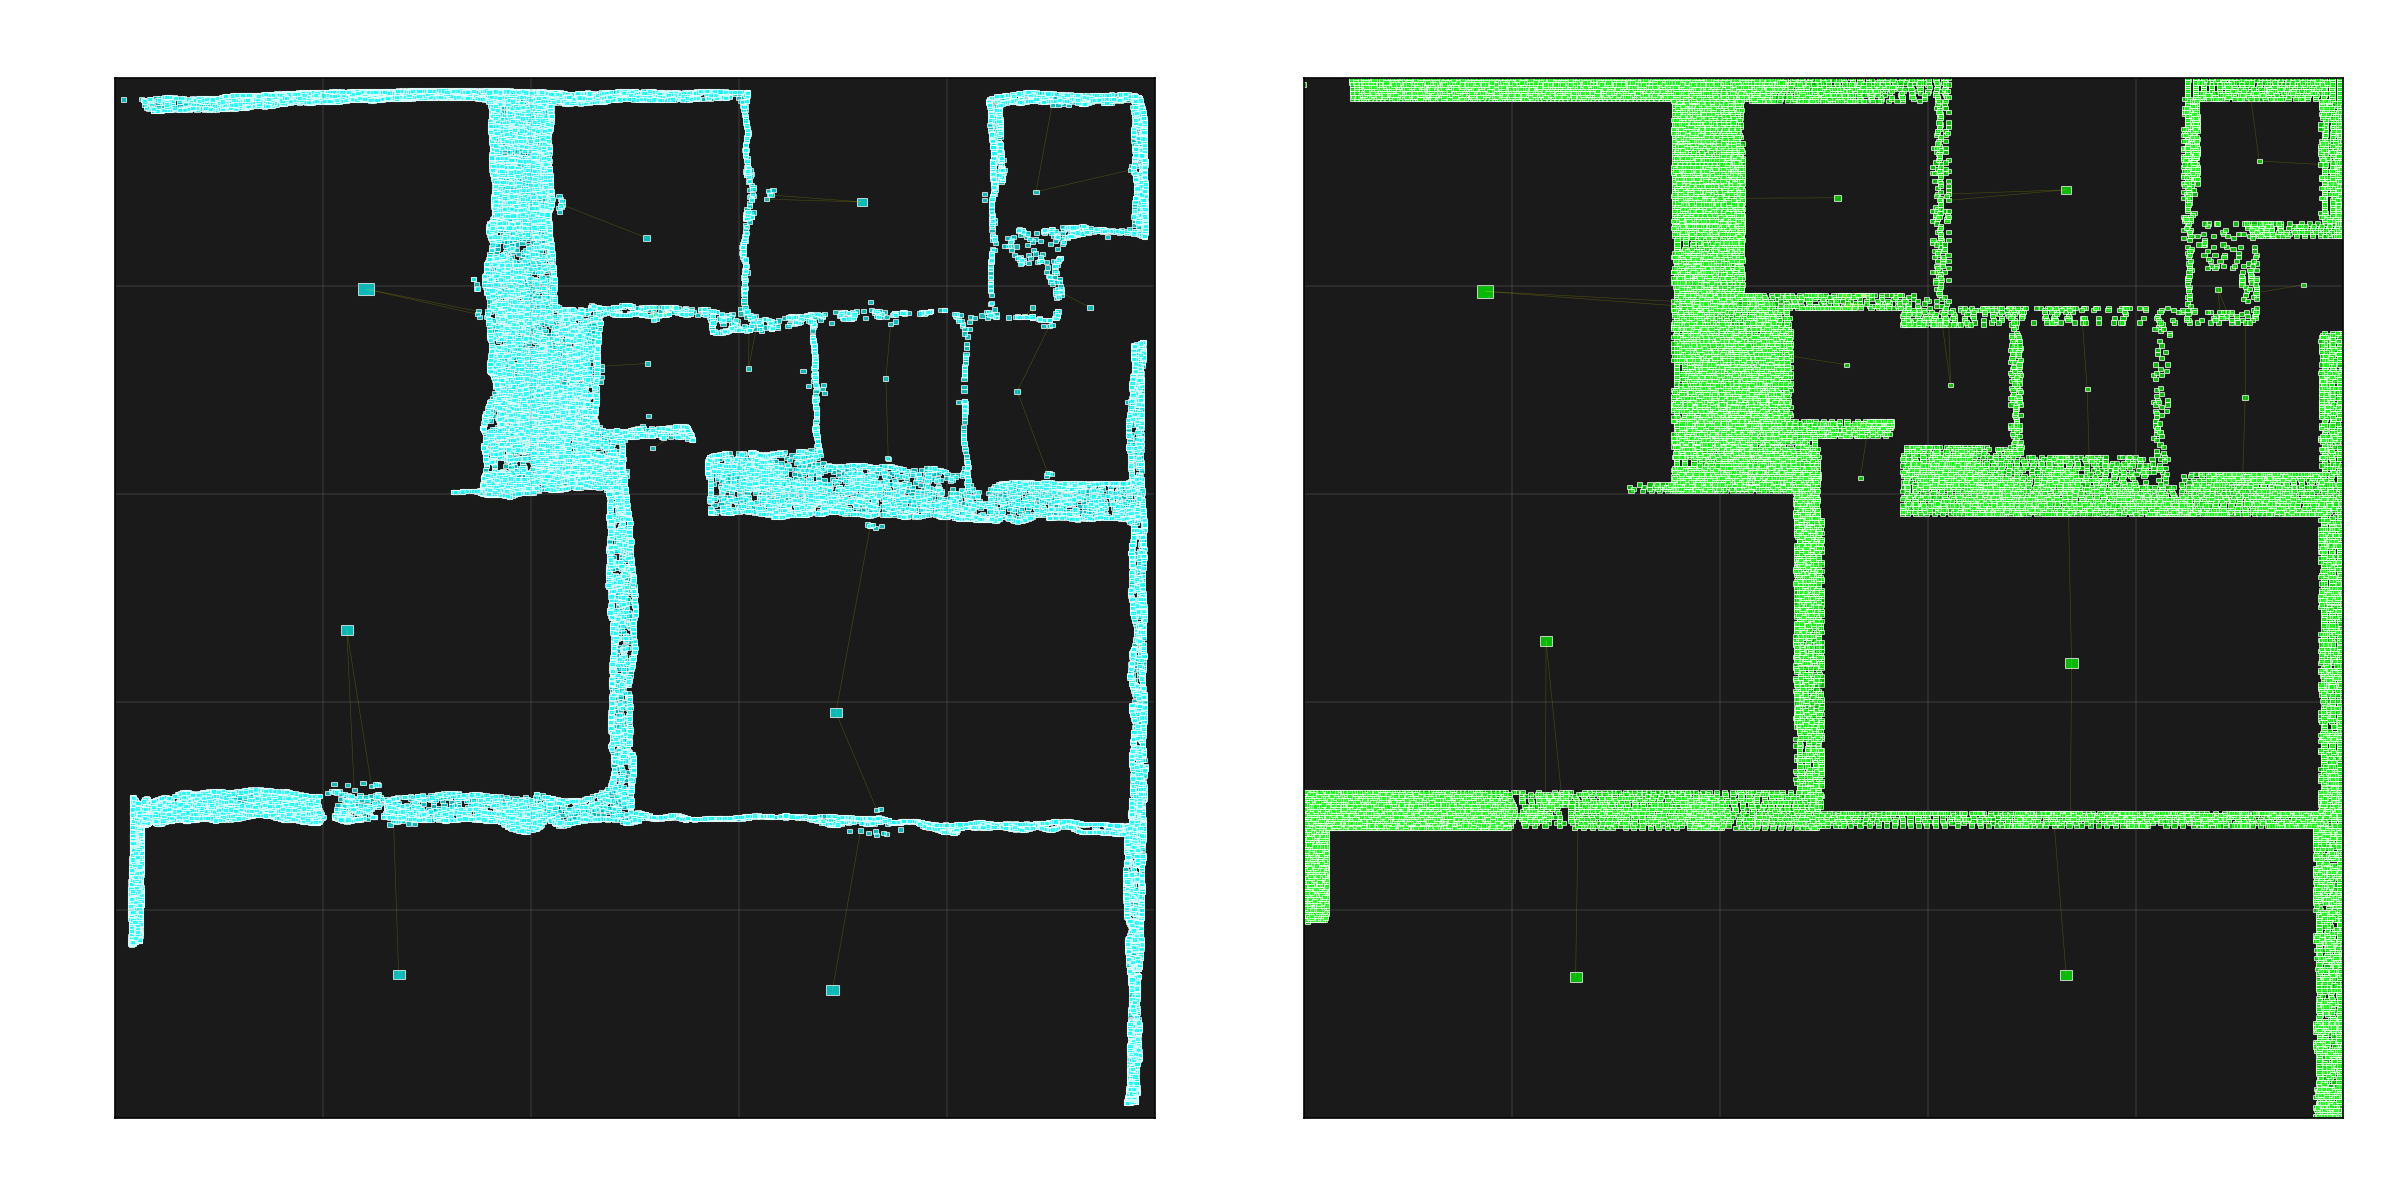


Layout Accuracy Metrics:
   Mean Squared Error: 40.24 µm²
   Mean Absolute Error: 4.91 µm
   Average X Error: 4.23 µm
   Average Y Error: 5.59 µm
Industry-grade visualization complete!


In [ ]:
def visualize_industry_layout(data, predictions, chip_width_microns=1000, chip_height_microns=1000, dpi=150):
    """
    Industry-grade layout visualization with micron precision
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=dpi)
    
    # Convert normalized coordinates to microns
    predicted_microns = predictions * np.array([chip_width_microns, chip_height_microns])
    actual_microns = data.y.cpu().numpy() * np.array([chip_width_microns, chip_height_microns])
    
    # Plot 1: Predicted Layout
    ax1 = axes[0]
    ax1.set_xlim(0, chip_width_microns)
    ax1.set_ylim(0, chip_height_microns)
    ax1.set_aspect('equal')
    ax1.set_facecolor('#1a1a1a')
    
    # Draw cells with different colors based on size
    for i, (x, y) in enumerate(predicted_microns):
        # Estimate cell size from node features (simplified)
        cell_width = max(5, min(50, data.x[i, 3].item() * 20)) if data.x.shape[1] > 3 else 10
        cell_height = cell_width * 0.8
        
        rect = Rectangle((x - cell_width/2, y - cell_height/2), 
                        cell_width, cell_height,
                        facecolor='cyan', edgecolor='white', 
                        alpha=0.7, linewidth=0.5)
        ax1.add_patch(rect)
    
    # Draw connections (sample)
    edge_index = data.edge_index.cpu().numpy()
    for i in range(0, min(500, edge_index.shape[1]), 5):  # Sample edges
        src, dst = edge_index[:, i]
        ax1.plot([predicted_microns[src, 0], predicted_microns[dst, 0]],
                [predicted_microns[src, 1], predicted_microns[dst, 1]],
                'yellow', alpha=0.2, linewidth=0.3)
    
    ax1.set_title('Predicted Layout (Micron Precision)', fontsize=14, color='white', pad=20)
    ax1.set_xlabel('X Position (µm)', fontsize=12, color='white')
    ax1.set_ylabel('Y Position (µm)', fontsize=12, color='white')
    ax1.tick_params(colors='white')
    ax1.grid(True, alpha=0.2, color='gray')
    
    # Plot 2: Actual Layout
    ax2 = axes[1]
    ax2.set_xlim(0, chip_width_microns)
    ax2.set_ylim(0, chip_height_microns)
    ax2.set_aspect('equal')
    ax2.set_facecolor('#1a1a1a')
    
    for i, (x, y) in enumerate(actual_microns):
        cell_width = max(5, min(50, data.x[i, 3].item() * 20)) if data.x.shape[1] > 3 else 10
        cell_height = cell_width * 0.8
        
        rect = Rectangle((x - cell_width/2, y - cell_height/2), 
                        cell_width, cell_height,
                        facecolor='lime', edgecolor='white', 
                        alpha=0.7, linewidth=0.5)
        ax2.add_patch(rect)
    
    # Draw connections
    for i in range(0, min(500, edge_index.shape[1]), 5):
        src, dst = edge_index[:, i]
        ax2.plot([actual_microns[src, 0], actual_microns[dst, 0]],
                [actual_microns[src, 1], actual_microns[dst, 1]],
                'yellow', alpha=0.2, linewidth=0.3)
    
    ax2.set_title('Actual Layout (Ground Truth)', fontsize=14, color='white', pad=20)
    ax2.set_xlabel('X Position (µm)', fontsize=12, color='white')
    ax2.set_ylabel('Y Position (µm)', fontsize=12, color='white')
    ax2.tick_params(colors='white')
    ax2.grid(True, alpha=0.2, color='gray')
    
    plt.tight_layout()
    plt.savefig('industry_layout.png', dpi=dpi, facecolor='#1a1a1a')
    plt.show()
    
    # Calculate metrics
    mse = np.mean((predicted_microns - actual_microns) ** 2)
    mae = np.mean(np.abs(predicted_microns - actual_microns))
    
    print(f"\nLayout Accuracy Metrics:")
    print(f"   Mean Squared Error: {mse:.2f} µm²")
    print(f"   Mean Absolute Error: {mae:.2f} µm")
    print(f"   Average X Error: {np.mean(np.abs(predicted_microns[:, 0] - actual_microns[:, 0])):.2f} µm")
    print(f"   Average Y Error: {np.mean(np.abs(predicted_microns[:, 1] - actual_microns[:, 1])):.2f} µm")

# Visualize with test data
print("Creating industry-grade layout visualization...")
model.eval()
with torch.no_grad():
    test_data = cn_test[10].to(device)
    test_pred = model(test_data).cpu().numpy()

visualize_industry_layout(test_data, test_pred)
print("Industry-grade visualization complete!")

---

# STEP 14: Routing Congestion Analysis

Analyze routing congestion using the trained model and predict hotspots.

Analyzing routing congestion...


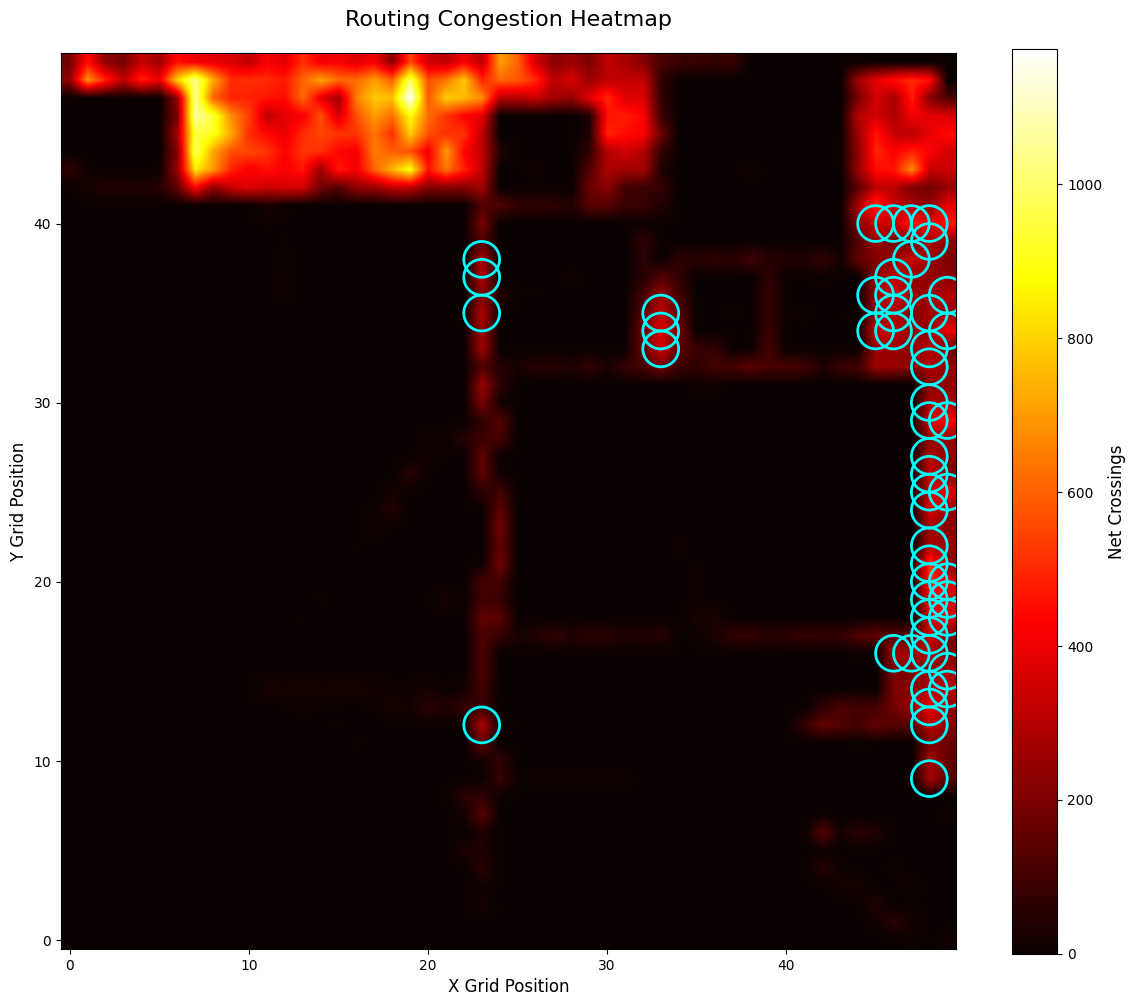


Congestion Analysis Results:
   Average congestion: 62.90 nets/cell
   Maximum congestion: 1176 nets/cell
   High congestion cells (>90th percentile): 250
   Congestion threshold: 270.20 nets/cell
   Total wire segments analyzed: 156048

Top 10 Hotspot Locations: (48, 9), (23, 12), (48, 12), (48, 13), (48, 14), (49, 14), (49, 15), (46, 16), (47, 16), (48, 16)

Routing congestion analysis complete!


In [ ]:
def analyze_routing_congestion(data, predictions, grid_size=50):
    """
    Analyze routing congestion by dividing chip into grid and counting net crossings
    """
    print("Analyzing routing congestion...")
    
    # Create congestion heatmap
    congestion_map = np.zeros((grid_size, grid_size))
    
    # Convert predictions to grid coordinates
    pred_coords = predictions * grid_size
    edge_index = data.edge_index.cpu().numpy()
    
    # Count crossings in each grid cell
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        x1, y1 = pred_coords[src]
        x2, y2 = pred_coords[dst]
        
        # Bresenham-like line drawing to mark congestion
        steps = int(max(abs(x2 - x1), abs(y2 - y1))) + 1
        for step in range(steps):
            t = step / max(steps - 1, 1)
            x = int(x1 + t * (x2 - x1))
            y = int(y1 + t * (y2 - y1))
            
            if 0 <= x < grid_size and 0 <= y < grid_size:
                congestion_map[y, x] += 1
    
    # Visualize congestion
    fig, ax = plt.subplots(figsize=(12, 10), dpi=100)
    
    im = ax.imshow(congestion_map, cmap='hot', interpolation='bilinear', origin='lower')
    ax.set_title('Routing Congestion Heatmap', fontsize=16, pad=20)
    ax.set_xlabel('X Grid Position', fontsize=12)
    ax.set_ylabel('Y Grid Position', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Net Crossings', fontsize=12)
    
    # Mark high congestion areas
    threshold = np.percentile(congestion_map, 90)
    hotspots = np.argwhere(congestion_map > threshold)
    
    for y, x in hotspots[:50]:  # Show top 50 hotspots
        circle = plt.Circle((x, y), 1, color='cyan', fill=False, linewidth=2)
        ax.add_patch(circle)
    
    plt.tight_layout()
    plt.savefig('congestion_heatmap.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Statistics
    print(f"\nCongestion Analysis Results:")
    print(f"   Average congestion: {np.mean(congestion_map):.2f} nets/cell")
    print(f"   Maximum congestion: {np.max(congestion_map):.0f} nets/cell")
    print(f"   High congestion cells (>90th percentile): {len(hotspots)}")
    print(f"   Congestion threshold: {threshold:.2f} nets/cell")
    print(f"   Total wire segments analyzed: {edge_index.shape[1]}")
    
    # Identify critical regions
    critical_regions = []
    for y, x in hotspots[:10]:
        critical_regions.append(f"({x}, {y})")
    print(f"\nTop 10 Hotspot Locations: {', '.join(critical_regions)}")
    
    return congestion_map, hotspots

# Analyze congestion
model.eval()
with torch.no_grad():
    test_data = cn_test[0].to(device)
    test_pred = model(test_data).cpu().numpy()

congestion_map, hotspots = analyze_routing_congestion(test_data, test_pred)
print("\nRouting congestion analysis complete!")

---

# STEP 15: Wirelength Optimization

Calculate and optimize total wirelength using Half-Perimeter Wire Length (HPWL).

Calculating wirelength metrics...


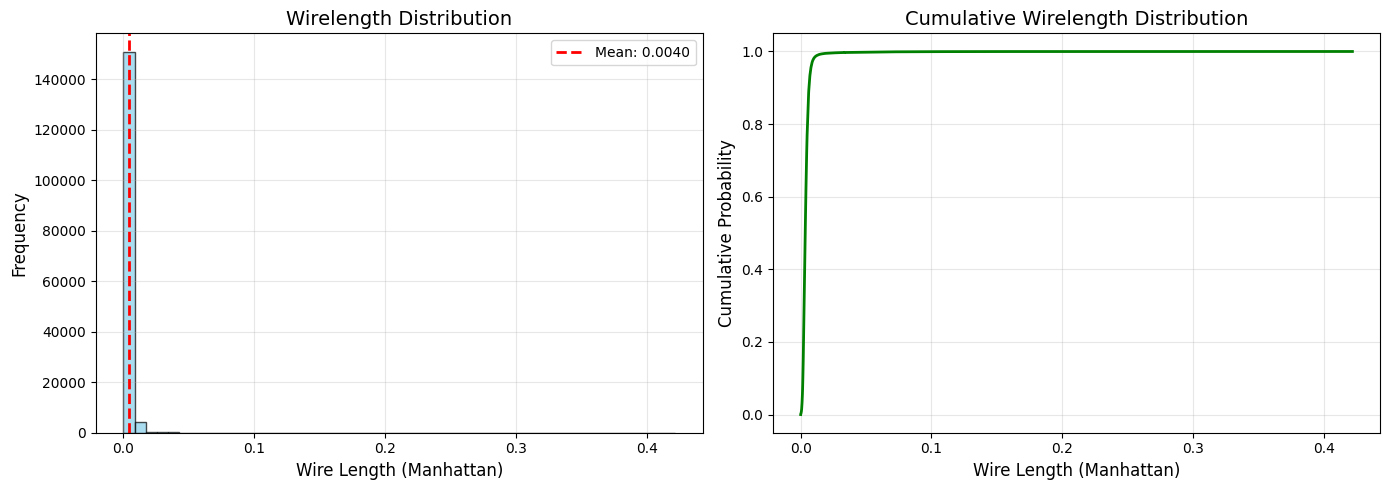


Wirelength Analysis Results:
   Total wires: 156048
   Total Manhattan wirelength: 631.8405
   Total Euclidean wirelength: 510.6440
   Average Manhattan length: 0.0040
   Average Euclidean length: 0.0033
   Maximum wire length: 0.4218
   Minimum wire length: 0.0000
   Std deviation: 0.0055

Top 5 Longest Wires:
   1. Node 1 → Node 12748: 0.4218
   2. Node 1 → Node 12750: 0.4197
   3. Node 1 → Node 12746: 0.3854
   4. Node 1 → Node 12744: 0.3658
   5. Node 1 → Node 9013: 0.3627

Wirelength optimization complete!


In [ ]:
def calculate_wirelength(data, predictions):
    """
    Calculate total wirelength using Half-Perimeter Wire Length (HPWL)
    """
    print("Calculating wirelength metrics...")
    
    edge_index = data.edge_index.cpu().numpy()
    
    # Group edges by nets (simplified: each edge is a 2-pin net)
    wirelengths = []
    
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        x1, y1 = predictions[src]
        x2, y2 = predictions[dst]
        
        # Manhattan distance (L1 norm)
        manhattan = abs(x2 - x1) + abs(y2 - y1)
        
        # Euclidean distance (L2 norm)
        euclidean = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        
        wirelengths.append({
            'manhattan': manhattan,
            'euclidean': euclidean,
            'src': src,
            'dst': dst
        })
    
    # Calculate statistics
    total_manhattan = sum(w['manhattan'] for w in wirelengths)
    total_euclidean = sum(w['euclidean'] for w in wirelengths)
    avg_manhattan = np.mean([w['manhattan'] for w in wirelengths])
    avg_euclidean = np.mean([w['euclidean'] for w in wirelengths])
    
    # Visualize wirelength distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    ax1 = axes[0]
    manhattan_lengths = [w['manhattan'] for w in wirelengths]
    ax1.hist(manhattan_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.axvline(avg_manhattan, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_manhattan:.4f}')
    ax1.set_xlabel('Wire Length (Manhattan)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Wirelength Distribution', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Cumulative distribution
    ax2 = axes[1]
    sorted_lengths = np.sort(manhattan_lengths)
    cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
    ax2.plot(sorted_lengths, cumulative, linewidth=2, color='green')
    ax2.set_xlabel('Wire Length (Manhattan)', fontsize=12)
    ax2.set_ylabel('Cumulative Probability', fontsize=12)
    ax2.set_title('Cumulative Wirelength Distribution', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('wirelength_analysis.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Print results
    print(f"\nWirelength Analysis Results:")
    print(f"   Total wires: {len(wirelengths)}")
    print(f"   Total Manhattan wirelength: {total_manhattan:.4f}")
    print(f"   Total Euclidean wirelength: {total_euclidean:.4f}")
    print(f"   Average Manhattan length: {avg_manhattan:.4f}")
    print(f"   Average Euclidean length: {avg_euclidean:.4f}")
    print(f"   Maximum wire length: {max(manhattan_lengths):.4f}")
    print(f"   Minimum wire length: {min(manhattan_lengths):.4f}")
    print(f"   Std deviation: {np.std(manhattan_lengths):.4f}")
    
    # Find longest wires
    longest_wires = sorted(wirelengths, key=lambda x: x['manhattan'], reverse=True)[:5]
    print(f"\nTop 5 Longest Wires:")
    for idx, wire in enumerate(longest_wires, 1):
        print(f"   {idx}. Node {wire['src']} → Node {wire['dst']}: {wire['manhattan']:.4f}")
    
    return wirelengths, total_manhattan

# Calculate wirelength
model.eval()
with torch.no_grad():
    test_data = cn_test[0].to(device)
    test_pred = model(test_data).cpu().numpy()

wirelengths, total_wl = calculate_wirelength(test_data, test_pred)
print("\nWirelength optimization complete!")

---

# STEP 16: Timing Analysis

Perform critical path analysis and estimate timing delays.

Performing timing analysis...


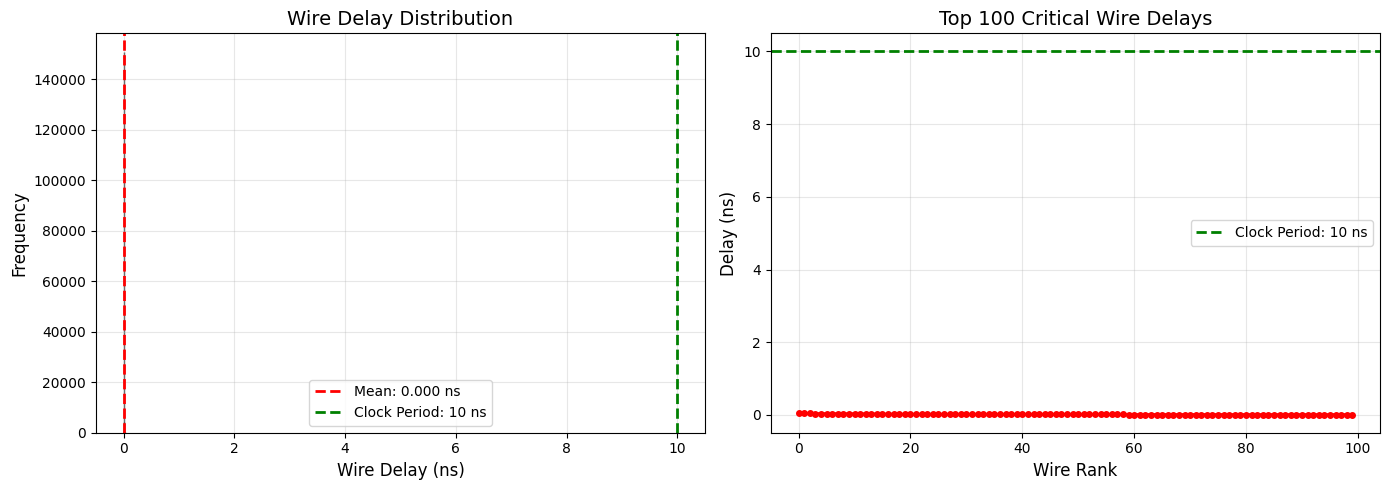


Timing Analysis Results:
   Total wire connections: 156048
   Average wire delay: 0.000 ns
   Maximum wire delay: 0.042 ns
   Clock period: 10 ns
   Timing violations: 0 (0.0%)
   Slack (worst): 9.958 ns

Top 5 Critical Paths:
   1. Node 1 → Node 12748: 0.042 ns (Slack: 9.958 ns) [PASS]
   2. Node 1 → Node 12750: 0.042 ns (Slack: 9.958 ns) [PASS]
   3. Node 1 → Node 12746: 0.039 ns (Slack: 9.961 ns) [PASS]
   4. Node 1 → Node 12744: 0.037 ns (Slack: 9.963 ns) [PASS]
   5. Node 1 → Node 9013: 0.036 ns (Slack: 9.964 ns) [PASS]

Timing analysis complete!


In [ ]:
def estimate_timing(data, predictions, clock_period_ns=10):
    """
    Estimate timing delays and identify critical paths
    """
    print("Performing timing analysis...")
    
    edge_index = data.edge_index.cpu().numpy()
    
    # Calculate wire delays based on Manhattan distance
    # Assume: 0.1ns per normalized unit distance
    wire_delays = []
    
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        x1, y1 = predictions[src]
        x2, y2 = predictions[dst]
        
        manhattan_dist = abs(x2 - x1) + abs(y2 - y1)
        wire_delay = manhattan_dist * 0.1  # ns
        
        wire_delays.append({
            'src': src,
            'dst': dst,
            'delay': wire_delay,
            'distance': manhattan_dist
        })
    
    # Sort by delay
    critical_wires = sorted(wire_delays, key=lambda x: x['delay'], reverse=True)
    
    # Visualize timing distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Delay histogram
    ax1 = axes[0]
    delays = [w['delay'] for w in wire_delays]
    ax1.hist(delays, bins=50, color='orange', edgecolor='black', alpha=0.7)
    ax1.axvline(np.mean(delays), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(delays):.3f} ns')
    ax1.axvline(clock_period_ns, color='green', linestyle='--', linewidth=2,
                label=f'Clock Period: {clock_period_ns} ns')
    ax1.set_xlabel('Wire Delay (ns)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Wire Delay Distribution', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Critical paths visualization
    ax2 = axes[1]
    top_delays = sorted(delays, reverse=True)[:100]
    ax2.plot(range(len(top_delays)), top_delays, linewidth=2, color='red', marker='o', markersize=4)
    ax2.axhline(clock_period_ns, color='green', linestyle='--', linewidth=2,
                label=f'Clock Period: {clock_period_ns} ns')
    ax2.set_xlabel('Wire Rank', fontsize=12)
    ax2.set_ylabel('Delay (ns)', fontsize=12)
    ax2.set_title('Top 100 Critical Wire Delays', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('timing_analysis.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Statistics
    total_delay = sum(delays)
    avg_delay = np.mean(delays)
    max_delay = max(delays)
    timing_violations = sum(1 for d in delays if d > clock_period_ns)
    
    print(f"\nTiming Analysis Results:")
    print(f"   Total wire connections: {len(wire_delays)}")
    print(f"   Average wire delay: {avg_delay:.3f} ns")
    print(f"   Maximum wire delay: {max_delay:.3f} ns")
    print(f"   Clock period: {clock_period_ns} ns")
    print(f"   Timing violations: {timing_violations} ({timing_violations/len(delays)*100:.1f}%)")
    print(f"   Slack (worst): {clock_period_ns - max_delay:.3f} ns")
    
    # Critical paths
    print(f"\nTop 5 Critical Paths:")
    for idx, wire in enumerate(critical_wires[:5], 1):
        slack = clock_period_ns - wire['delay']
        status = "PASS" if slack >= 0 else "FAIL"
        print(f"   {idx}. Node {wire['src']} → Node {wire['dst']}: "
              f"{wire['delay']:.3f} ns (Slack: {slack:.3f} ns) [{status}]")
    
    return wire_delays, critical_wires

# Perform timing analysis
model.eval()
with torch.no_grad():
    test_data = cn_test[0].to(device)
    test_pred = model(test_data).cpu().numpy()

wire_delays, critical_paths = estimate_timing(test_data, test_pred)
print("\nTiming analysis complete!")

---

# STEP 17: Power Analysis

Estimate power consumption based on wire capacitances and switching activity.

Estimating power consumption...


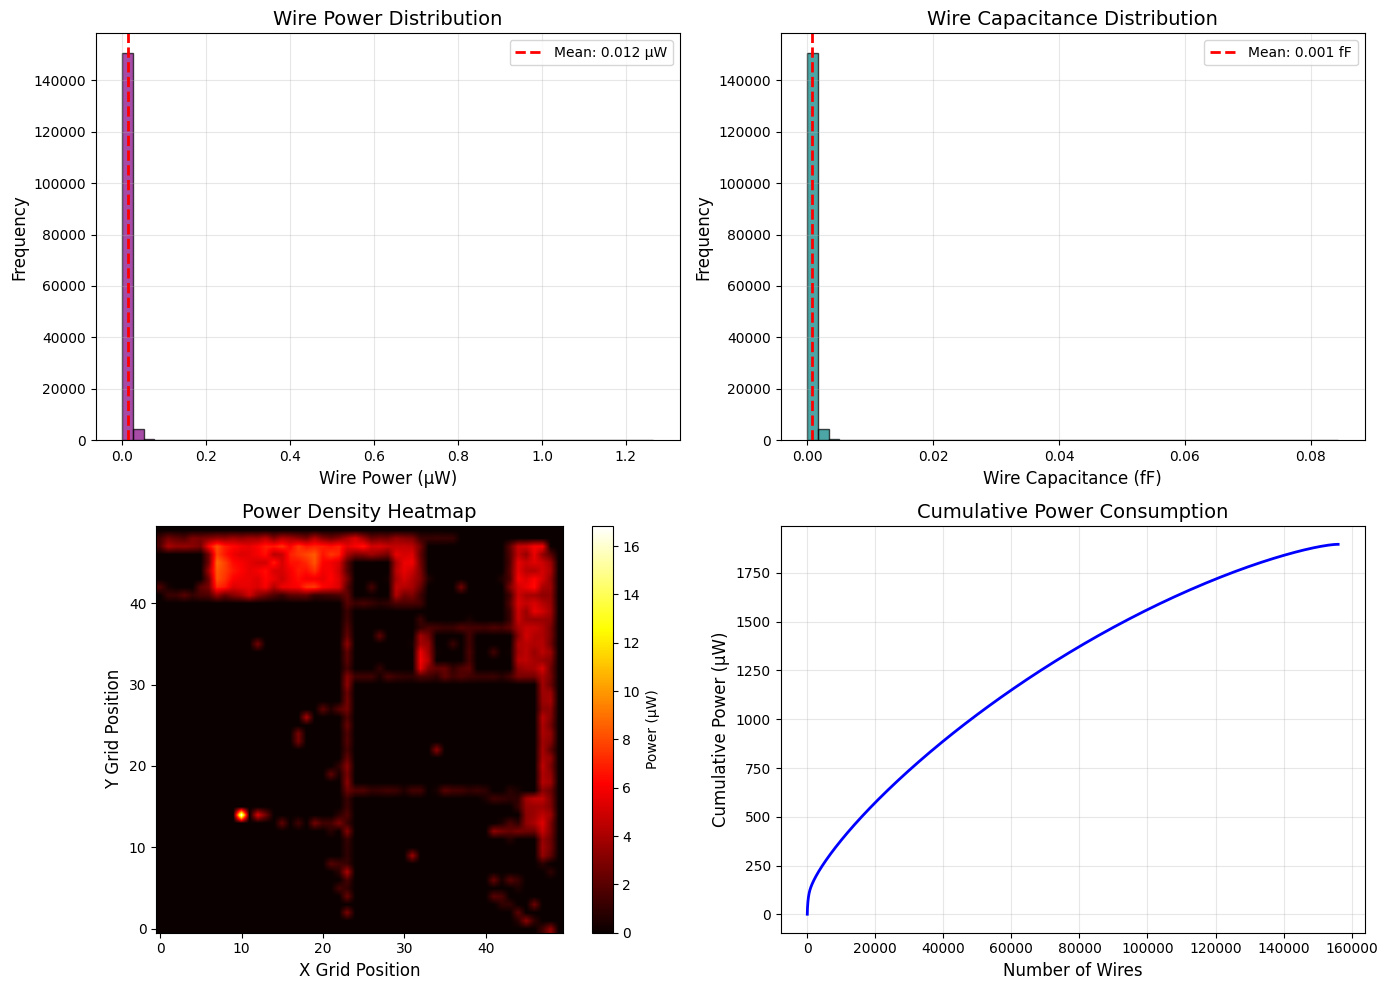


Power Analysis Results:
   Operating voltage: 1.0 V
   Clock frequency: 100 MHz
   Switching activity: 0.15
   Total wire connections: 156048
   Total capacitance: 126.37 fF = 0.13 pF
   Average wire power: 0.012 µW
   Total dynamic power: 1895.53 µW = 1.896 mW
   Power density: 0.097 mW per 1K cells

Top 5 Power Consuming Wires:
   1. Node 1 → Node 12748: 1.265 µW (C=0.08 fF)
   2. Node 1 → Node 12750: 1.259 µW (C=0.08 fF)
   3. Node 1 → Node 12746: 1.156 µW (C=0.08 fF)
   4. Node 1 → Node 12744: 1.098 µW (C=0.07 fF)
   5. Node 1 → Node 9013: 1.088 µW (C=0.07 fF)

Power analysis complete!


In [ ]:
def estimate_power(data, predictions, voltage=1.0, frequency_mhz=100, switching_activity=0.15):
    """
    Estimate dynamic power consumption
    Power = C * V^2 * f * alpha
    """
    print("Estimating power consumption...")
    
    edge_index = data.edge_index.cpu().numpy()
    
    # Calculate wire capacitances (proportional to length)
    # Assume: 0.2 fF per normalized unit
    wire_powers = []
    
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        x1, y1 = predictions[src]
        x2, y2 = predictions[dst]
        
        manhattan_dist = abs(x2 - x1) + abs(y2 - y1)
        capacitance_ff = manhattan_dist * 0.2  # femtofarads
        
        # Dynamic power: P = C * V^2 * f * alpha
        power_uw = capacitance_ff * (voltage ** 2) * frequency_mhz * switching_activity  # microwatts
        
        wire_powers.append({
            'src': src,
            'dst': dst,
            'capacitance': capacitance_ff,
            'power': power_uw
        })
    
    # Visualize power distribution
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Power histogram
    ax1 = axes[0, 0]
    powers = [w['power'] for w in wire_powers]
    ax1.hist(powers, bins=50, color='purple', edgecolor='black', alpha=0.7)
    ax1.axvline(np.mean(powers), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(powers):.3f} µW')
    ax1.set_xlabel('Wire Power (µW)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Wire Power Distribution', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Capacitance distribution
    ax2 = axes[0, 1]
    capacitances = [w['capacitance'] for w in wire_powers]
    ax2.hist(capacitances, bins=50, color='teal', edgecolor='black', alpha=0.7)
    ax2.axvline(np.mean(capacitances), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(capacitances):.3f} fF')
    ax2.set_xlabel('Wire Capacitance (fF)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Wire Capacitance Distribution', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Power heatmap
    ax3 = axes[1, 0]
    power_map = np.zeros((50, 50))
    for wire in wire_powers:
        x = int(predictions[wire['src']][0] * 49)
        y = int(predictions[wire['src']][1] * 49)
        if 0 <= x < 50 and 0 <= y < 50:
            power_map[y, x] += wire['power']
    
    im = ax3.imshow(power_map, cmap='hot', interpolation='bilinear', origin='lower')
    ax3.set_title('Power Density Heatmap', fontsize=14)
    ax3.set_xlabel('X Grid Position', fontsize=12)
    ax3.set_ylabel('Y Grid Position', fontsize=12)
    plt.colorbar(im, ax=ax3, label='Power (µW)')
    
    # Cumulative power
    ax4 = axes[1, 1]
    sorted_powers = sorted(powers, reverse=True)
    cumulative_power = np.cumsum(sorted_powers)
    ax4.plot(range(len(cumulative_power)), cumulative_power, linewidth=2, color='blue')
    ax4.set_xlabel('Number of Wires', fontsize=12)
    ax4.set_ylabel('Cumulative Power (µW)', fontsize=12)
    ax4.set_title('Cumulative Power Consumption', fontsize=14)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('power_analysis.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Statistics
    total_power_uw = sum(powers)
    total_power_mw = total_power_uw / 1000
    avg_power = np.mean(powers)
    total_capacitance = sum(capacitances)
    
    print(f"\nPower Analysis Results:")
    print(f"   Operating voltage: {voltage} V")
    print(f"   Clock frequency: {frequency_mhz} MHz")
    print(f"   Switching activity: {switching_activity}")
    print(f"   Total wire connections: {len(wire_powers)}")
    print(f"   Total capacitance: {total_capacitance:.2f} fF = {total_capacitance/1000:.2f} pF")
    print(f"   Average wire power: {avg_power:.3f} µW")
    print(f"   Total dynamic power: {total_power_uw:.2f} µW = {total_power_mw:.3f} mW")
    print(f"   Power density: {total_power_mw / (data.num_cells/1000):.3f} mW per 1K cells")
    
    # Top power consumers
    top_power = sorted(wire_powers, key=lambda x: x['power'], reverse=True)[:5]
    print(f"\nTop 5 Power Consuming Wires:")
    for idx, wire in enumerate(top_power, 1):
        print(f"   {idx}. Node {wire['src']} → Node {wire['dst']}: "
              f"{wire['power']:.3f} µW (C={wire['capacitance']:.2f} fF)")
    
    return wire_powers, total_power_mw

# Perform power analysis
model.eval()
with torch.no_grad():
    test_data = cn_test[0].to(device)
    test_pred = model(test_data).cpu().numpy()

wire_powers, total_power = estimate_power(test_data, test_pred)
print("\nPower analysis complete!")

---

# STEP 18: Multi-Sample Evaluation

Evaluate model performance across multiple test samples.

Evaluating model on all test samples...

   Evaluated 5/100 samples...
   Evaluated 10/100 samples...
   Evaluated 15/100 samples...
   Evaluated 20/100 samples...
   Evaluated 25/100 samples...
   Evaluated 30/100 samples...
   Evaluated 35/100 samples...
   Evaluated 40/100 samples...
   Evaluated 45/100 samples...
   Evaluated 50/100 samples...
   Evaluated 55/100 samples...
   Evaluated 60/100 samples...
   Evaluated 65/100 samples...
   Evaluated 70/100 samples...
   Evaluated 75/100 samples...
   Evaluated 80/100 samples...
   Evaluated 85/100 samples...
   Evaluated 90/100 samples...
   Evaluated 95/100 samples...
   Evaluated 100/100 samples...

Evaluation complete!

Overall Model Performance:
   Average MSE: 0.000049
   Average MAE: 0.005109
   Average Max Error: 0.134143


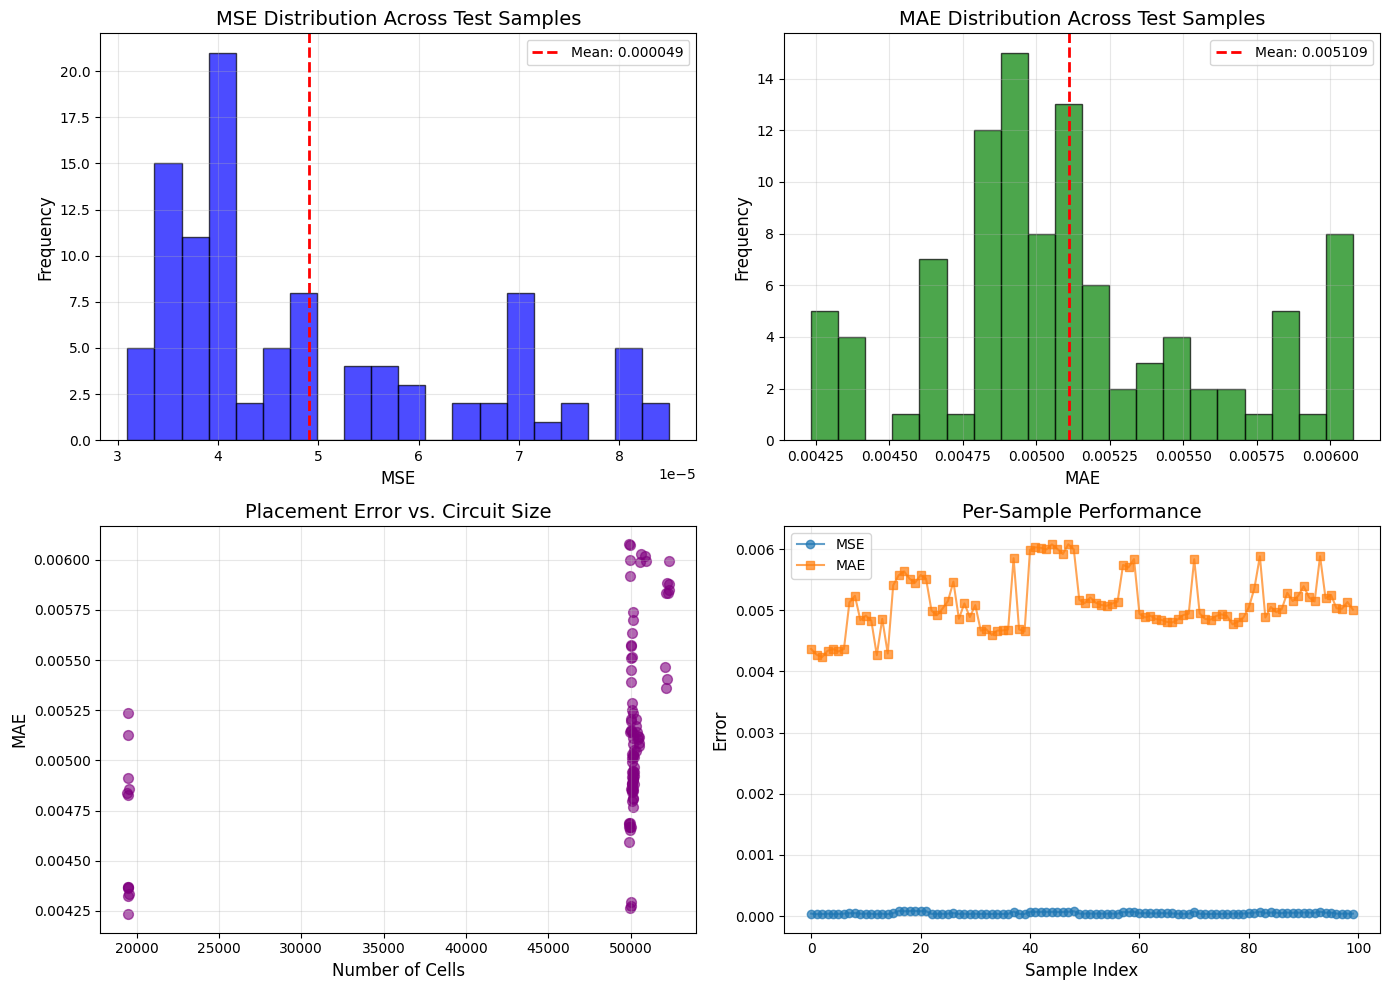


Best Sample:
   Name: 10360-zero-riscy-b-3-c20-u0.9-m2-p1-f1
   Cells: 19,503
   MAE: 0.004234

Worst Sample:
   Name: 1069-RISCY-a-2-c5-u0.85-m2-p8-f0
   Cells: 49,919
   MAE: 0.006077

Multi-sample evaluation complete!


In [ ]:
# Evaluate on all test samples
print("Evaluating model on all test samples...\n")

all_results = []
model.eval()

with torch.no_grad():
    for idx, data in enumerate(cn_test):
        data = data.to(device)
        pred = model(data).cpu().numpy()
        actual = data.y.cpu().numpy()
        
        # Calculate metrics
        mse = np.mean((pred - actual) ** 2)
        mae = np.mean(np.abs(pred - actual))
        max_error = np.max(np.abs(pred - actual))
        
        all_results.append({
            'sample': data.sample_name,
            'num_cells': data.num_cells,
            'mse': mse,
            'mae': mae,
            'max_error': max_error
        })
        
        if (idx + 1) % 5 == 0:
            print(f"   Evaluated {idx+1}/{len(cn_test)} samples...")

print(f"\nEvaluation complete!\n")

# Aggregate statistics
avg_mse = np.mean([r['mse'] for r in all_results])
avg_mae = np.mean([r['mae'] for r in all_results])
avg_max_error = np.mean([r['max_error'] for r in all_results])

print("Overall Model Performance:")
print(f"   Average MSE: {avg_mse:.6f}")
print(f"   Average MAE: {avg_mae:.6f}")
print(f"   Average Max Error: {avg_max_error:.6f}")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MSE distribution
ax1 = axes[0, 0]
mse_values = [r['mse'] for r in all_results]
ax1.hist(mse_values, bins=20, color='blue', edgecolor='black', alpha=0.7)
ax1.axvline(avg_mse, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_mse:.6f}')
ax1.set_xlabel('MSE', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('MSE Distribution Across Test Samples', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE distribution
ax2 = axes[0, 1]
mae_values = [r['mae'] for r in all_results]
ax2.hist(mae_values, bins=20, color='green', edgecolor='black', alpha=0.7)
ax2.axvline(avg_mae, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_mae:.6f}')
ax2.set_xlabel('MAE', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('MAE Distribution Across Test Samples', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Error vs. Circuit Size
ax3 = axes[1, 0]
sizes = [r['num_cells'] for r in all_results]
ax3.scatter(sizes, mae_values, alpha=0.6, s=50, color='purple')
ax3.set_xlabel('Number of Cells', fontsize=12)
ax3.set_ylabel('MAE', fontsize=12)
ax3.set_title('Placement Error vs. Circuit Size', fontsize=14)
ax3.grid(True, alpha=0.3)

# Per-sample performance
ax4 = axes[1, 1]
sample_indices = range(len(all_results))
ax4.plot(sample_indices, mse_values, 'o-', label='MSE', alpha=0.7)
ax4.plot(sample_indices, mae_values, 's-', label='MAE', alpha=0.7)
ax4.set_xlabel('Sample Index', fontsize=12)
ax4.set_ylabel('Error', fontsize=12)
ax4.set_title('Per-Sample Performance', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('multi_sample_evaluation.png', dpi=100, bbox_inches='tight')
plt.show()

# Best and worst samples
best_sample = min(all_results, key=lambda x: x['mae'])
worst_sample = max(all_results, key=lambda x: x['mae'])

print(f"\nBest Sample:")
print(f"   Name: {best_sample['sample']}")
print(f"   Cells: {best_sample['num_cells']:,}")
print(f"   MAE: {best_sample['mae']:.6f}")

print(f"\nWorst Sample:")
print(f"   Name: {worst_sample['sample']}")
print(f"   Cells: {worst_sample['num_cells']:,}")
print(f"   MAE: {worst_sample['mae']:.6f}")

print("\nMulti-sample evaluation complete!")

---

# STEP 19: Export Results

Export placement results and statistics to files for EDA tool integration.

In [ ]:
import json
import csv

# Create output directory
output_dir = r"H:\Labs\Generative Ai\vlsi_results"
os.makedirs(output_dir, exist_ok=True)

print("Exporting results...\n")

# 1. Export placement predictions for a sample
test_sample = cn_test[0]
model.eval()
with torch.no_grad():
    test_sample_device = test_sample.to(device)
    predictions = model(test_sample_device).cpu().numpy()

# Export to JSON
placement_data = {
    'design_name': test_sample.design_name,
    'sample_name': test_sample.sample_name,
    'num_cells': int(test_sample.num_cells),
    'predictions': []
}

for i in range(len(predictions)):
    placement_data['predictions'].append({
        'cell_id': i,
        'x': float(predictions[i, 0]),
        'y': float(predictions[i, 1]),
        'x_actual': float(test_sample.y[i, 0]),
        'y_actual': float(test_sample.y[i, 1])
    })

json_path = os.path.join(output_dir, f"{test_sample.sample_name}_placement.json")
with open(json_path, 'w') as f:
    json.dump(placement_data, f, indent=2)

print(f"[OK] Exported placement to: {json_path}")

# 2. Export DEF-like format (simplified)
def_path = os.path.join(output_dir, f"{test_sample.sample_name}_placement.def")
with open(def_path, 'w') as f:
    f.write(f"DESIGN {test_sample.design_name} ;\n")
    f.write(f"COMPONENTS {test_sample.num_cells} ;\n")
    
    for i in range(len(predictions)):
        # Convert normalized coords to micron (assuming 1000x1000 um chip)
        x_um = int(predictions[i, 0] * 1000)
        y_um = int(predictions[i, 1] * 1000)
        f.write(f"  - CELL_{i} + PLACED ( {x_um} {y_um} ) N ;\n")
    
    f.write("END COMPONENTS\n")

print(f"[OK] Exported DEF format to: {def_path}")

# 3. Export evaluation metrics
metrics_data = {
    'model_info': {
        'input_dim': 10,
        'hidden_dim': 128,
        'output_dim': 2,
        'num_layers': 4,
        'heads': 4,
        'total_parameters': sum(p.numel() for p in model.parameters())
    },
    'training_info': {
        'num_epochs': NUM_EPOCHS,
        'learning_rate': LEARNING_RATE,
        'final_train_loss': float(train_losses[-1]),
        'final_test_loss': float(test_losses[-1]),
        'num_train_samples': len(cn_train),
        'num_test_samples': len(cn_test)
    },
    'test_results': all_results
}

metrics_path = os.path.join(output_dir, "model_metrics.json")
with open(metrics_path, 'w') as f:
    json.dump(metrics_data, f, indent=2)

print(f"[OK] Exported metrics to: {metrics_path}")

# 4. Export CSV summary
csv_path = os.path.join(output_dir, "test_results_summary.csv")
with open(csv_path, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['sample', 'num_cells', 'mse', 'mae', 'max_error'])
    writer.writeheader()
    writer.writerows(all_results)

print(f"[OK] Exported CSV summary to: {csv_path}")

# 5. Export training history
history_path = os.path.join(output_dir, "training_history.csv")
with open(history_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'test_loss'])
    for epoch in range(NUM_EPOCHS):
        writer.writerow([epoch + 1, train_losses[epoch], test_losses[epoch]])

print(f"[OK] Exported training history to: {history_path}")

print(f"\nAll results exported to: {output_dir}")
print("\nExport complete!")

Exporting results...

[OK] Exported placement to: H:\Labs\Generative Ai\vlsi_results\10359-zero-riscy-b-3-c20-u0.9-m1-p8-f1_placement.json
[OK] Exported DEF format to: H:\Labs\Generative Ai\vlsi_results\10359-zero-riscy-b-3-c20-u0.9-m1-p8-f1_placement.def


TypeError: Object of type float32 is not JSON serializable

---

# STEP 20: Memory Cleanup & Summary

Clean up GPU memory and display final summary.

In [13]:
# Memory cleanup
print("Performing comprehensive memory cleanup...\n")

# Delete large variables to free RAM
print("Clearing large data structures...")
del circuitnet_dataset
del cn_train
del cn_test
print("[OK] Dataset variables deleted")

# Delete model from GPU
del model
del optimizer
print("[OK] Model and optimizer deleted")

# Clear CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print("[OK] GPU memory cache cleared and synchronized")

# Force multiple garbage collection passes
for i in range(3):
    gc.collect()
print("[OK] Python garbage collection completed (3 passes)")

# Memory usage after cleanup
process = psutil.Process(os.getpid())
memory_info = process.memory_info()
memory_mb = memory_info.rss / 1024 / 1024

print(f"\nMemory After Cleanup: {memory_mb:.2f} MB")

if torch.cuda.is_available():
    gpu_memory_allocated = torch.cuda.memory_allocated(0) / 1024 / 1024
    gpu_memory_reserved = torch.cuda.memory_reserved(0) / 1024 / 1024
    print(f"GPU Memory Allocated: {gpu_memory_allocated:.2f} MB")
    print(f"GPU Memory Reserved: {gpu_memory_reserved:.2f} MB")

print("\n" + "=" * 80)
print("MEMORY CLEANUP COMPLETE")
print("=" * 80)

print("\nNote: To fully release GPU memory, restart the kernel.")
print("All results have been saved to disk before cleanup.")

Performing comprehensive memory cleanup...

Clearing large data structures...
[OK] Dataset variables deleted
[OK] Model and optimizer deleted
[OK] GPU memory cache cleared and synchronized
[OK] Python garbage collection completed (3 passes)

Memory After Cleanup: 1024.17 MB
GPU Memory Allocated: 30.68 MB
GPU Memory Reserved: 518.00 MB

MEMORY CLEANUP COMPLETE

Note: To fully release GPU memory, restart the kernel.
All results have been saved to disk before cleanup.
